# Portfolio Analyzer

This notebook analyzes your Trading 212 portfolio to identify undervalued stocks using mean analyst price targets and a P/E-based intrinsic value model.

In [43]:
pip install requests yfinance pandas matplotlib tabulate

Note: you may need to restart the kernel to use updated packages.


In [44]:
import requests
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from typing import Dict, List
import time

In [ ]:
class StockAnalyzer:
    def __init__(self, api_key: str):
        self.api_key = api_key
        self.base_url = "https://live.trading212.com/api/v0/equity/portfolio"
        self.headers = {
            "Authorization": api_key,
            "Content-Type": "application/json"
        }

    def get_portfolio(self) -> List[Dict]:
        """Fetch the user's portfolio from the Trading 212 API."""
        try:
            response = requests.get(self.base_url, headers=self.headers)
            response.raise_for_status()
            return response.json()
        except Exception as e:
            print(f"Error fetching portfolio: {e}")
            return []

    def clean_ticker(self, ticker: str) -> str:
        """Remove broker-specific suffixes and map special cases to Yahoo Finance-compatible tickers."""
        # Remove known suffixes
        for suffix in [
            "_US_EQ", "_EQ_US", "_LN_EQ", "_DE_EQ", "_FR_EQ",
            "_IT_EQ", "_ES_EQ", "_CH_EQ", "_JP_EQ", "_EQ"
        ]:
            if ticker.endswith(suffix):
                ticker = ticker[:-len(suffix)]

        # Map known renamed or merged tickers
        ticker_map = {
            "FB": "META",    # Facebook -> Meta Platforms
            "OAC": "HIMS",   # Oaktree Acquisition -> Hims & Hers Health
            "AGC": "GRAB",   # Altimeter Growth -> Grab Holdings
            "IPOE": "SOFI",  # Social Capital Hedosophia V -> SoFi
        }
        ticker = ticker_map.get(ticker, ticker)
        return ticker

    def get_stock_data(self, ticker: str) -> Dict:
        """Fetch stock data from Yahoo Finance."""
        cleaned_ticker = self.clean_ticker(ticker)
        try:
            info = yf.Ticker(cleaned_ticker).info
            sector = info.get('sector', 'Unknown')
            return {
                'ticker': cleaned_ticker,
                'current_price': info.get('currentPrice', 0),
                'eps': info.get('trailingEps', 0),
                'sector': sector,
                'sector_pe': self._get_sector_pe(sector),
                'target_mean_price': info.get('targetMeanPrice', 0)
            }
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
            return None
        finally:
            time.sleep(1)  # Rate limiting

    def _get_sector_pe(self, sector: str) -> float:
        """Return a rough P/E average for a given sector."""
        sector_pe_map = {
            'Technology': 25.0,
            'Healthcare': 20.0,
            'Financial Services': 15.0,
            'Consumer Cyclical': 18.0,
            'Industrials': 16.0,
            'Energy': 12.0,
            'Basic Materials': 14.0,
            'Communication Services': 22.0,
            'Consumer Defensive': 17.0,
            'Real Estate': 15.0,
            'Utilities': 16.0,
            'Unknown': 15.0
        }
        return sector_pe_map.get(sector, 15.0)

    def analyze_portfolio(self) -> List[Dict]:
        """Analyze each holding and estimate valuation metrics."""
        portfolio = self.get_portfolio()
        analyzed = []

        for pos in portfolio:
            ticker = pos.get('ticker')
            if not ticker:
                continue

            stock = self.get_stock_data(ticker)
            if not stock:
                continue

            eps = stock['eps']
            current = stock['current_price']
            intrinsic = eps * stock['sector_pe'] if eps > 0 else 0
            price_to_intrinsic = current / intrinsic if intrinsic > 0 else float('inf')
            target = stock['target_mean_price']
            upside_pct = (target / current - 1) if target > 0 and current > 0 else 0

            analyzed.append({
                'ticker': stock['ticker'],
                'current_price': current,
                'target_mean': target,
                'target_upside': upside_pct,
                'price_to_intrinsic': price_to_intrinsic,
                'intrinsic_value': intrinsic,
                'sector': stock['sector']
            })

        # Sort by target upside
        return sorted(analyzed, key=lambda x: x['target_upside'], reverse=True)

    def print_recommendations(self, stocks: List[Dict]):
        """Print top stock recommendations based on target price upside."""
        if not stocks:
            print("No recommendations available.")
            return

        table = []
        for s in stocks:
            if s['target_mean'] <= 0:
                continue
            table.append([
                s['ticker'],
                f"${s['current_price']:.2f}",
                f"${s['target_mean']:.2f}",
                f"{s['target_upside'] * 100:.1f}%",
                f"{s['price_to_intrinsic']:.2f}" if s['price_to_intrinsic'] != float('inf') else "N/A"
            ])

        print("\nStocks Ranked by Analyst Target Upside:")
        print(tabulate(
            table,
            headers=["Ticker", "Current Price", "Target Price", "% Upside", "Price/Intrinsic"],
            tablefmt="grid"
        ))


def main():
    api_key = ""  # Replace with your actual key
    analyzer = StockAnalyzer(api_key)
    results = analyzer.analyze_portfolio()
    recommendations = analyzer.analyze_portfolio()
    df = pd.DataFrame(recommendations)
    analyzer.print_recommendations(results[:10])  # Display top 10 by upside


if __name__ == "__main__":
    main()



Stocks Ranked by Analyst Target Upside:
+----------+-----------------+----------------+------------+-------------------+
| Ticker   | Current Price   | Target Price   | % Upside   |   Price/Intrinsic |
+==========+=================+================+============+===================+
| GOOGL    | $159.53         | $200.56        | 25.7%      |              0.81 |
+----------+-----------------+----------------+------------+-------------------+
| NVDA     | $129.93         | $163.03        | 25.5%      |              1.77 |
+----------+-----------------+----------------+------------+-------------------+
| GRAB     | $5.03           | $5.76          | 14.6%      |             20.12 |
+----------+-----------------+----------------+------------+-------------------+
| AMD      | $112.46         | $126.98        | 12.9%      |              3.28 |
+----------+-----------------+----------------+------------+-------------------+
| MSFT     | $449.14         | $506.17        | 12.7%      |        

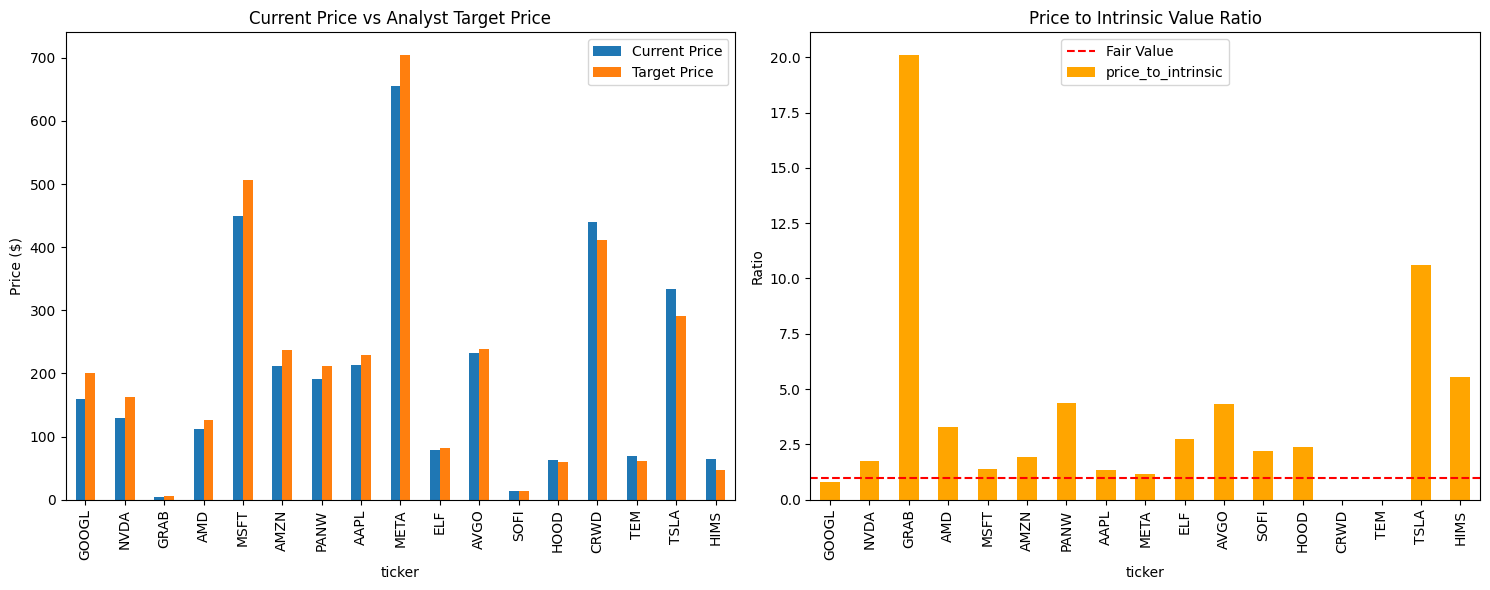

In [46]:
# Create visualizations 
if recommendations:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Left plot - Current Price vs Analyst Target Price ---
    df.plot(kind='bar', x='ticker', y=['current_price', 'target_mean'], ax=ax1)
    ax1.set_title('Current Price vs Analyst Target Price')
    ax1.set_ylabel('Price ($)')
    ax1.legend(['Current Price', 'Target Price'])

    # Right plot - Price to Intrinsic Value Ratio ---
    df.plot(kind='bar', x='ticker', y='price_to_intrinsic', ax=ax2, color='orange')
    ax2.set_title('Price to Intrinsic Value Ratio')
    ax2.set_ylabel('Ratio')
    ax2.axhline(y=1, color='r', linestyle='--', label='Fair Value')
    ax2.legend()

    plt.tight_layout()
    plt.show()
else:
    print("No recommendations available to plot.")
